# hdf5plugin benchmark

This notebook displays benchmark of the HDF5 compression filters provided by [hdf5plugin](https://github.com/silx-kit/hdf5plugin) as well as "gzip" and "lzf".
Benchmarks can be run with the [benchmark.py](benchmark.py) companion script and saved as json files that this notebooks can load and display.

## Preparation

Dependencies: h5py ipympl matplotlib numpy

### Install `hdf5plugin`

- Pre-compiled package:
  - Only SSE2 SIMD instructions enabled
  - OpenMP disabled
  - `pip install hdf5plugin` or `conda install -c conda-forge hdf5plugin`
- From source:
  - SIMD instructions available on host enabled
  - OpenMP enabled
  - `pip install hdf5plugin --no-binary hdf5plugin`

### Get dataset

Download benchmark dataset: http://www.silx.org/pub/pyFAI/pyFAI_UM_2020/data_ID13/kevlar.h5

In [ ]:
!wget -O /dev/shm/kevlar.h5 http://www.silx.org/pub/pyFAI/pyFAI_UM_2020/data_ID13/kevlar.h5

### What hardware is available

The CPU layout can have a significative impact on performance for multi-threaded execution

In [1]:
!numactl --hardware

available: 2 nodes (0-1)
node 0 cpus: 0 2 4 6 8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38
node 0 size: 192072 MB
node 0 free: 170763 MB
node 1 cpus: 1 3 5 7 9 11 13 15 17 19 21 23 25 27 29 31 33 35 37 39
node 1 size: 193489 MB
node 1 free: 164284 MB
node distances:
node   0   1 
  0:  10  21 
  1:  21  10 


### Load plotting function

In [2]:
# Initialization
#%matplotlib inline
%matplotlib widget

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

import numpy
import h5py
import hdf5plugin
from h5glance import H5Glance

In [3]:
# Plot helper

from typing import NamedTuple

class Result(NamedTuple):
    """Store benchmark result"""

    raw_nbytes: int
    compressed_nbytes: int
    write_duration: float
    read_duration: float
    chunks: tuple[int]

    compression_rate = property(
        lambda self: self.raw_nbytes / self.compressed_nbytes)
    write_speed = property(
        lambda self: (self.raw_nbytes / 1024**2) / self.write_duration,
        doc="Unit: MB/sec")
    read_speed = property(
        lambda self: (self.raw_nbytes / 1024**2) / self.read_duration,
        doc="Unit: MB/sec")

    
def display_results(title: str='', key=None, **results):
    """Plot comparison of compression results.
    
    :param title: Additional dataset name
    :param key: Key function to customize the sort
    :param **results: {compression-name: Result} mapping 
    """
    # Sort results by compression rate
    results = dict(sorted(
        results.items(),
        key=(lambda item: item[1].compression_rate) if key is None else key,
    ))
    
    names = list(results.keys())
    write_speed = numpy.array([r.write_speed for r in results.values()])
    read_speed = numpy.array([r.read_speed for r in results.values()])
    c_rate = numpy.array([r.compression_rate for r in results.values()])
    
    #print(f"hdf5plugin_config: {results[names[0]].config}")

    fig, axes = plt.subplots(1, 2)
    speed_plt, c_rate_plt = axes

    fig.suptitle(title)

    ticks = numpy.arange(len(names))

    # Speed
    speed_plt.barh(y=ticks, width=write_speed, height=0.4, align='edge', label="Write")
    speed_plt.barh(y=ticks-.4, width=read_speed, height=0.4, align='edge', label="Read")
    speed_plt.set_xlabel("Speed [MB/s]")
    speed_plt.autoscale(axis='y')
    speed_plt.yaxis.set_ticks(ticks)
    speed_plt.yaxis.set_ticklabels(names, fontsize=8)
    speed_plt.set_ylim(-0.5, len(ticks)-0.5)
    speed_plt.grid(axis="x")
    speed_plt.legend()
    
    # Compression ratio
    c_rate_plt.barh(y=ticks, width=c_rate)
    c_rate_plt.set_xlabel("Compression rate")
    c_rate_plt.autoscale(axis='y')
    c_rate_plt.yaxis.set_ticks(ticks)
    c_rate_plt.yaxis.set_ticklabels([''] * len(ticks))
    c_rate_plt.set_ylim(-0.5,len(ticks)-0.5)
    c_rate_plt.axvline(1, color="red")
    c_rate_plt.grid(axis="x")

    fig.tight_layout()

    # Tooltip
    tooltip = c_rate_plt.annotate(
        "", (0, 0), backgroundcolor="lightyellow",
        verticalalignment="top", xycoords='figure pixels')
    tooltip.set_visible(False)

    def hover(event):
        if event.inaxes in (speed_plt, c_rate_plt):
            index = numpy.clip(round(event.ydata), 0, len(names)-1)
            tooltip.set_text(
                f"{names[index]}\n"
                f"Comp. Rate: {c_rate[index]:.2f}x\n"
                f"Write: {write_speed[index]:.1f}MB/s\n"
                f"Read: {read_speed[index]:.1f}MB/s")
            tooltip.set_x(event.x + 15)
            tooltip.set_y(event.y)
            tooltip.set_visible(True)
        else:
            tooltip.set_visible(False)
        fig.canvas.draw_idle()
    
    def resize(event):
        fig.tight_layout()

    fig.canvas.mpl_connect("motion_notify_event", hover)
    fig.canvas.mpl_connect("resize_event", resize)

### Display information

In [4]:
import os
import sys

print('Python:', sys.version)

config = hdf5plugin.get_config()
print(f"""hdf5plugin:
* Version: {hdf5plugin.version}
* Build config:
{'''
'''.join(f'  - {k}: {v}' for k, v in config.build_config._asdict().items())}
""")

Python: 3.9.12 | packaged by conda-forge | (main, Mar 24 2022, 23:22:55) 
[GCC 10.3.0]
hdf5plugin:
* Version: 4.2.0
* Build config:
  - openmp: True
  - native: True
  - bmi2: True
  - sse2: True
  - avx2: True
  - avx512: False
  - cpp11: True
  - cpp14: True
  - ipp: False
  - filter_file_extension: .so
  - embedded_filters: ('blosc', 'blosc2', 'bshuf', 'bzip2', 'fcidecomp', 'lz4', 'sz', 'sz3', 'zfp', 'zstd')



## Benchmark results

In [5]:
import json

benchmarks = json.load(open("benchmark.json"))
config = benchmarks["config"]
results = {k: Result(**v) for k, v in benchmarks["results"].items()}

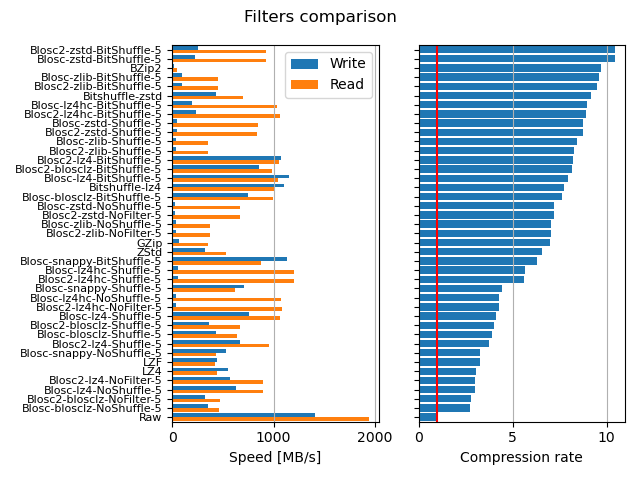

In [6]:
display_results(
    title="Filters comparison",
    **results
)